In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torchvision.models import detection
import torchvision
import torch.nn as nn
from tqdm import tqdm, tqdm_notebook
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!pip install opencv-contrib-python --upgrade

     |████████████████████████████████| 56.1 MB 88 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [13]:
import cv2
print(cv2.__version__)

4.5.3


In [3]:
class Mock():
    def __init__(self, out_size):
        self.out_size = out_size

    def eval(self):
        pass
    
    def __call__(self, x):
        return torch.ones((x.size()[0], self.out_size))

In [4]:
!unzip -q drive/MyDrive/'Colab Notebooks'/name.zip

In [5]:
def get_cropped_image(picture, coordinates, expand_coeff=2.0):
        '''
            picture: torch.Tensor
            coordinates: "indexed set" of 4 coordinates: [x1, y1, x2, y2]
        '''
        x = coordinates[0]
        y = coordinates[1]
        w = coordinates[2] - coordinates[0]
        h = coordinates[3] - coordinates[1]
        w_expanded = int(w * expand_coeff)
        h_expanded = int(h * expand_coeff)
        x_expanded = int(x - (w_expanded - w) / 2.0)
        y_expanded = int(y - (h_expanded - h) / 2.0)

        return torchvision.transforms.functional.crop(
            picture, 
            int(y_expanded), 
            int(x_expanded), 
            int(h_expanded), 
            int(w_expanded),
        )

In [87]:
class ColorDetector():
    def __init__(self, colors, THRESHOLD=1./8):
        self.THRESHOLD = THRESHOLD
        self.colors = np.array(colors)
    
    def __call__(self, image):
        image = image[0]
        h = int(self.THRESHOLD * image.shape[1])
        w = int(self.THRESHOLD * image.shape[2])
        x1 = image.shape[2] // 2 - w // 2
        y1 = image.shape[1] // 2 - h // 2
        x2 = image.shape[2] // 2 + w // 2
        y2 = image.shape[1] // 2 + h // 2
        cropped_image = get_cropped_image(image, [x1, y1, x2, y2], expand_coeff=1.0)
        plt.imshow(cropped_image.permute(1, 2, 0).detach().numpy())
        plt.show()
        color = [0] * cropped_image.shape[0]
        for channel in range(cropped_image.shape[0]):
            color[channel] = cropped_image[channel].mean().item() * 256
        color = np.array(color)
        print(color)
        print(np.sum((self.colors - color) ** 2.0, axis=1))
        return np.argmin(np.sum((self.colors - color) ** 2.0, axis=1))

In [7]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [72]:
colors = {"orange": (255,165,0),"gold": (255,215,0),"dark golden rod": (184,134,11),"golden rod": (218,165,32),"pale golden rod": (238,232,170),"dark khaki": (189,183,107),"khaki": (240,230,140),"olive": (128,128,0),"yellow": (255,255,0),"yellow green": (154,205,50),"dark olive green": (85,107,47),"olive drab": (107,142,35),"lawn green": (124,252,0),"chart reuse": (127,255,0),"green yellow": (173,255,47),"dark green": (0,100,0),"green": (0,128,0),"forest green": (34,139,34),"lime": (0,255,0),"lime green": (50,205,50),"light green": (144,238,144),"pale green": (152,251,152),"dark sea green": (143,188,143),"medium spring green": (0,250,154),"spring green": (0,255,127),"sea green": (46,139,87),"medium aqua marine": (102,205,170),"medium sea green": (60,179,113),"light sea green": (32,178,170),"dark slate gray": (47,79,79),"teal": (0,128,128),"dark cyan": (0,139,139),"aqua": (0,255,255),"cyan": (0,255,255),"light cyan": (224,255,255),"dark turquoise": (0,206,209),"turquoise": (64,224,208),"medium turquoise": (72,209,204),"pale turquoise": (175,238,238),"aqua marine": (127,255,212),"powder blue": (176,224,230),"cadet blue": (95,158,160),"steel blue": (70,130,180),"corn flower blue": (100,149,237),"deep sky blue": (0,191,255),"dodger blue": (30,144,255),"light blue": (173,216,230),"sky blue": (135,206,235),"light sky blue": (135,206,250),"midnight blue": (25,25,112),"navy": (0,0,128),"dark blue": (0,0,139),"medium blue": (0,0,205),"blue": (0,0,255),"royal blue": (65,105,225),"blue violet": (138,43,226),"indigo": (75,0,130),"dark slate blue": (72,61,139),"slate blue": (106,90,205),"medium slate blue": (123,104,238),"medium purple": (147,112,219),"dark magenta": (139,0,139),"dark violet": (148,0,211),"dark orchid": (153,50,204),"medium orchid": (186,85,211),"purple": (128,0,128),"thistle": (216,191,216),"plum": (221,160,221),"violet": (238,130,238),"magenta / fuchsia": (255,0,255),"orchid": (218,112,214),"medium violet red": (199,21,133),"pale violet red": (219,112,147),"deep pink": (255,20,147),"hot pink": (255,105,180),"light pink": (255,182,193),"pink": (255,192,203),"antique white": (250,235,215),"beige": (245,245,220),"bisque": (255,228,196),"blanched almond": (255,235,205),"wheat": (245,222,179),"corn silk": (255,248,220),"lemon chiffon": (255,250,205),"light golden rod yellow": (250,250,210),"light yellow": (255,255,224),"saddle brown": (139,69,19),"sienna": (160,82,45),"chocolate": (210,105,30),"peru": (205,133,63),"sandy brown": (244,164,96),"burly wood": (222,184,135),"tan": (210,180,140),"rosy brown": (188,143,143),"moccasin": (255,228,181),"navajo white": (255,222,173),"peach puff": (255,218,185),"misty rose": (255,228,225),"lavender blush": (255,240,245),"linen": (250,240,230),"old lace": (253,245,230),"papaya whip": (255,239,213),"sea shell": (255,245,238),"mint cream": (245,255,250),"slate gray": (112,128,144),"light slate gray": (119,136,153),"light steel blue": (176,196,222),"lavender": (230,230,250),"floral white": (255,250,240),"alice blue": (240,248,255),"ghost white": (248,248,255),"honeydew": (240,255,240),"ivory": (255,255,240),"azure": (240,255,255),"snow": (255,250,250),"black": (0,0,0),"dim gray / dim grey": (105,105,105),"gray / grey": (128,128,128),"dark gray / dark grey": (169,169,169),"silver": (192,192,192),"light gray / light grey": (211,211,211),"gainsboro": (220,220,220),"white smoke": (245,245,245),"white": (255,255,255),}

In [77]:
colors_vec = list(colors.values())
colors_names = list(colors.keys())
colors_index = {i: colors_names[i] for i in range(len(colors))}
print(colors_vec)
print(colors_names)
# colors_rev =  {value : key for (key, value) in a_dictionary.items()}

[(255, 165, 0), (255, 215, 0), (184, 134, 11), (218, 165, 32), (238, 232, 170), (189, 183, 107), (240, 230, 140), (128, 128, 0), (255, 255, 0), (154, 205, 50), (85, 107, 47), (107, 142, 35), (124, 252, 0), (127, 255, 0), (173, 255, 47), (0, 100, 0), (0, 128, 0), (34, 139, 34), (0, 255, 0), (50, 205, 50), (144, 238, 144), (152, 251, 152), (143, 188, 143), (0, 250, 154), (0, 255, 127), (46, 139, 87), (102, 205, 170), (60, 179, 113), (32, 178, 170), (47, 79, 79), (0, 128, 128), (0, 139, 139), (0, 255, 255), (0, 255, 255), (224, 255, 255), (0, 206, 209), (64, 224, 208), (72, 209, 204), (175, 238, 238), (127, 255, 212), (176, 224, 230), (95, 158, 160), (70, 130, 180), (100, 149, 237), (0, 191, 255), (30, 144, 255), (173, 216, 230), (135, 206, 235), (135, 206, 250), (25, 25, 112), (0, 0, 128), (0, 0, 139), (0, 0, 205), (0, 0, 255), (65, 105, 225), (138, 43, 226), (75, 0, 130), (72, 61, 139), (106, 90, 205), (123, 104, 238), (147, 112, 219), (139, 0, 139), (148, 0, 211), (153, 50, 204), (186,

In [8]:
# picture: torch.Tensor or np.array
# boxes: indexed object
# labels: indexed object
def draw_pic_with_rect(picture, boxes, labels, n=5):
    boxes = boxes[:n]
    labels = labels[:n]
    if isinstance(picture, torch.Tensor):
        picture = (picture.detach().squeeze(0) * 256).permute(1, 2, 0).numpy()
    picture = picture.astype(dtype=np.int)

    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(picture)

    for box, lab in zip(boxes, labels):
        rect = matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.text(box[0], box[1], inst_classes[lab], fontsize = 12)
        ax.add_patch(rect)

    fig.show()

In [9]:
indices_animal_detection = [
    inst_classes.index("bird"),
    inst_classes.index("cat"),
    inst_classes.index("dog"),
    inst_classes.index("horse"),
    inst_classes.index("sheep"),
    inst_classes.index("cow"),
    inst_classes.index("elephant"),
    inst_classes.index("bear"),
    inst_classes.index("zebra"),
    inst_classes.index("giraffe"),
]

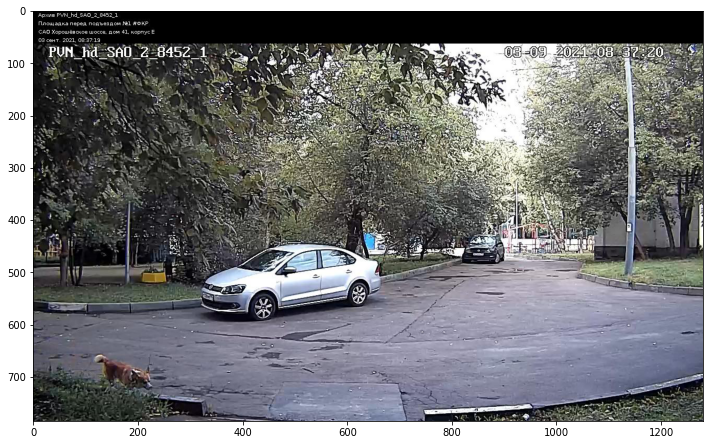

In [85]:
image = Image.open("/content/Датасет/Только собака/ТОЛЬКО СОБАКА ТЕМНЫЙ ДЛИННЫЙ/326.jpg")
image_numpy = np.asarray(image)
plt.figure(figsize=(12, 10))
plt.imshow(image_numpy);
# find_lost_animal.get_features(image_numpy)

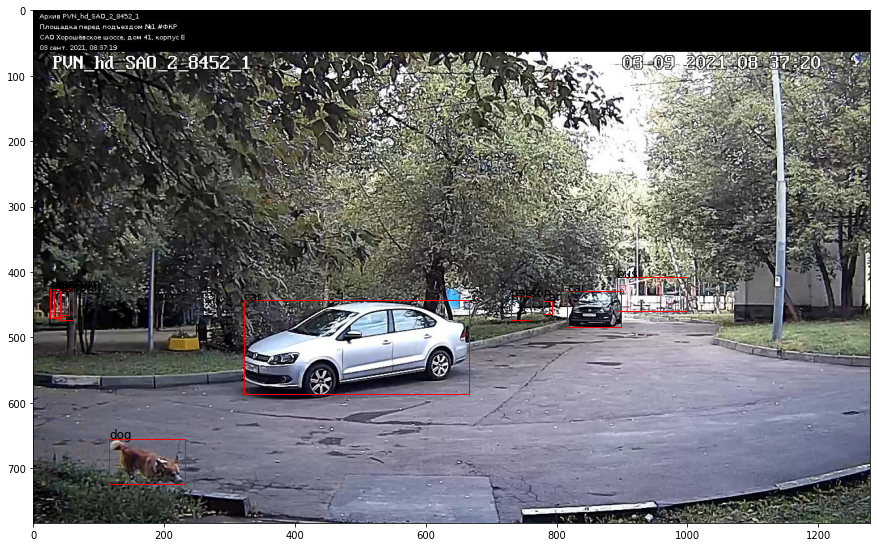

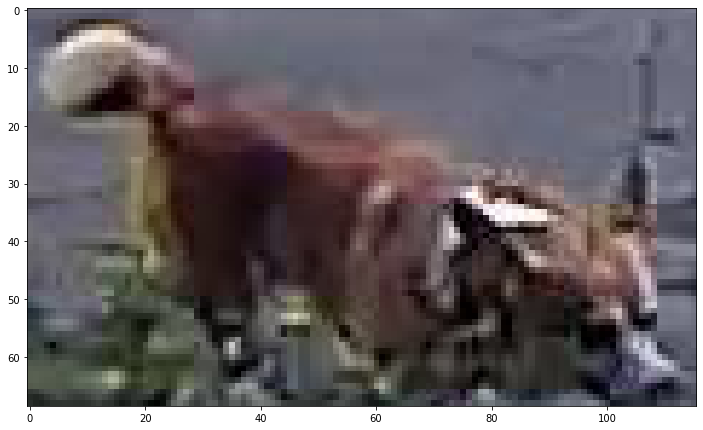

dingo
Chesapeake_Bay_retriever
Rhodesian_ridgeback


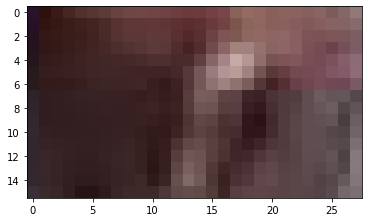

[85.2857132  58.74106979 60.2075882 ]
[ 43718.8530704   56844.74609103  17829.80373111  29699.71020236
  65394.68398013  28386.46482577  59632.96069827  10246.26338687
  70945.46050753  26217.52273288   2503.44636264   8038.98221316
  42472.7637836   43882.60308566  46385.80418124  12600.90587344
  15695.40596499   9758.5579349   49416.17423739  22740.9510776
  42602.2998096   49840.1391727   26893.39339175  52650.64777102
  50252.44683566   8702.69646945  33725.41573825  17888.61633029
  29116.43335452   2229.37482943  16666.26338687  19923.3929111
  83735.30425753  83735.30425753  95703.30474582  51098.02721133
  49606.19258609  43430.51397433  71792.55901065  63298.58569064
  64369.05894961  19905.22804751  19661.71008792  39618.74158969
  62710.16119113  48269.67895999  61253.63034549  54709.09006228
  60177.86241641   7455.28092685  15319.97725405  16932.41031375
  31689.0086719   48668.24985232  29707.93777194  30513.70112338
   8427.2899219    6389.85709872  22371.04491153  3508

In [88]:
class FindLostAnimal():
    def __init__(self, 
                 model_detection,
                 model_classification_animal,
                 model_classification_dog_breed,
                 model_classification_dog_color,
                 model_classification_dog_tail,
                 indices_animal_detection,
                 indices_cat_dog_classification,
                 converter_dog_breed,
                 converter_dog_color,
                 converter_dog_tail,
        ):

        self.model_detection = model_detection
        self.model_classification_animal = model_classification_animal
        self.model_classification_dog_breed = model_classification_dog_breed
        self.model_classification_dog_color = model_classification_dog_color
        self.model_classification_dog_tail = model_classification_dog_tail
        self.indices_cat_dog_classification = indices_cat_dog_classification
        self.indices_animal_detection  = indices_animal_detection
        self.converter_dog_breed = converter_dog_breed
        self.converter_dog_color = converter_dog_color
        self.converter_dog_tail = converter_dog_tail

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225],
            ),
            # torchvision.transforms.Resize((80, 80)),
        ])

        self.model_detection.eval()
        self.model_classification_animal.eval()
        self.model_classification_dog_breed.eval()
        # self.model_classification_dog_color.eval()
        self.model_classification_dog_tail.eval()


    def __get_detection_predictions(self, picture):
        pred = self.model_detection(picture)
        return pred[0]["boxes"], pred[0]["labels"]
    
    def __get_classification_animal_predictions(self, cropped_picture):
        '''
            determine class of an animal
        '''
        pred = self.model_classification_animal(cropped_picture)
        label = pred.argmax(axis=1)[0].item()
        return label

    def show_picture(self, picture):
        plt.figure(figsize=(12, 10))
        plt.imshow(picture[0].permute(1, 2, 0).detach().numpy())
        plt.show()

    def __convert_features(self, features):
        result = []
        for data in features:
            result.append(
                [
                 self.converter_dog_breed[str(data[0])],
                 self.converter_dog_color[data[1]], 
                 self.converter_dog_tail[data[2]], 
                ]
            )
        return result

    def __get_dog_features(self, dog_image):
        normalized_picture = self.transforms(dog_image)

        arr = self.model_classification_dog_breed(normalized_picture)[0].detach().numpy()
        ind = arr.argsort()[-3:][::-1]
        for breed in ind:
            print(self.converter_dog_breed[str(breed)])
        
        return [
                self.model_classification_dog_breed(normalized_picture).argmax(axis=1)[0].item(),
                self.model_classification_dog_color(dog_image), 
                self.model_classification_dog_tail(normalized_picture).argmax(axis=1)[0].item(), 
        ]
        

    def get_features(self, picture_numpy):
        features = []
        # convert picture in tensor
        picture = torch.from_numpy(picture_numpy).\
        to(dtype=torch.float32).permute(2, 0, 1) / 256
        picture.unsqueeze_(0)
        boxes, labels = self.__get_detection_predictions(picture)
        draw_pic_with_rect(picture, boxes, labels, 10)
        for box, label in zip(boxes, labels):
            # if it is an animal than we should check it
            if label in self.indices_animal_detection:
                cropped_image = get_cropped_image(picture, box, 2.0)
                pred = self.__get_classification_animal_predictions(
                    self.transforms(cropped_image)
                )
                # if it is a dog
                if pred in self.indices_cat_dog_classification:
                    self.show_picture(get_cropped_image(picture, box, 1.0))
                    features.append(self.__get_dog_features(cropped_image))
                    # cropped_image_numpy = (
                    #     get_cropped_image(picture, box, 1.0)[0].\
                    #     permute(1, 2, 0).\
                    #     detach().\
                    #     numpy() * 256
                    # ).astype(dtype=np.uint8)
                    # image = Image.fromarray(cropped_image_numpy)
                    # image.save("test.jpg")

        return self.__convert_features(features)

find_lost_animal = FindLostAnimal(
    model_detection,
    model_classification_cat_dog, 
    model_classification_dog_breed,
    ColorDetector(colors_vec),
    Mock(2),
    indices_animal_detection,
    [1],
    breeds_converter,
    colors_names,
    {0: "enormous"}
)


print(
    find_lost_animal.get_features(image_numpy)
)

# model_detection,
# model_classification_animal,
# model_classification_dog_breed,
# model_classification_dog_color,
# model_classification_dog_tail,
# indices_animal_detection,
# indices_cat_dog_classification,
# converter_dog_breed,
# converter_dog_color,
# converter_dog_tail,

In [60]:
breeds_converter = {"0": "Japanese_spaniel", "1": "Pekinese", "2": "Blenheim_spaniel", "3": "toy_terrier", "4": "Rhodesian_ridgeback", "5": "basset", "6": "beagle", "7": "bluetick", "8": "black-and-tan_coonhound", "9": "Walker_hound", "10": "English_foxhound", "11": "redbone", "12": "borzoi", "13": "Norwegian_elkhound", "14": "Scottish_deerhound", "15": "Weimaraner", "16": "Staffordshire_bullterrier", "17": "American_Staffordshire_terrier", "18": "Border_terrier", "19": "Irish_terrier", "20": "Norfolk_terrier", "21": "Norwich_terrier", "22": "Yorkshire_terrier", "23": "wire-haired_fox_terrier", "24": "Lakeland_terrier", "25": "Airedale", "26": "cairn", "27": "giant_schnauzer", "28": "standard_schnauzer", "29": "soft-coated_wheaten_terrier", "30": "West_Highland_white_terrier", "31": "flat-coated_retriever", "32": "golden_retriever", "33": "Labrador_retriever", "34": "Chesapeake_Bay_retriever", "35": "Irish_setter", "36": "Gordon_setter", "37": "Brittany_spaniel", "38": "Welsh_springer_spaniel", "39": "cocker_spaniel", "40": "Sussex_spaniel", "41": "Irish_water_spaniel", "42": "briard", "43": "kelpie", "44": "Shetland_sheepdog", "45": "collie", "46": "Rottweiler", "47": "Doberman", "48": "boxer", "49": "Tibetan_mastiff", "50": "malamute", "51": "Siberian_husky", "52": "pug", "53": "Leonberg", "54": "Newfoundland", "55": "Great_Pyrenees", "56": "Samoyed", "57": "Pomeranian", "58": "chow", "59": "standard_poodle", "60": "dingo"}

In [ ]:
model_classification_cat_dog(torchvision.transforms.Compose([
            torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225],
            ),
            torchvision.transforms.Resize((80, 80)),
        ])(torch.from_numpy(image_numpy).to(dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)))

tensor([[ 1.8643, 14.3293]], grad_fn=<AddmmBackward>)

In [43]:
image_torch = (torch.from_numpy(image_numpy).\
        to(dtype=torch.float32).permute(2, 0, 1) / 256).unsqueeze_(0)
model_detection.eval()
prediction = model_detection(image_torch)
boxes, labels = prediction[0]['boxes'], prediction[0]['labels']

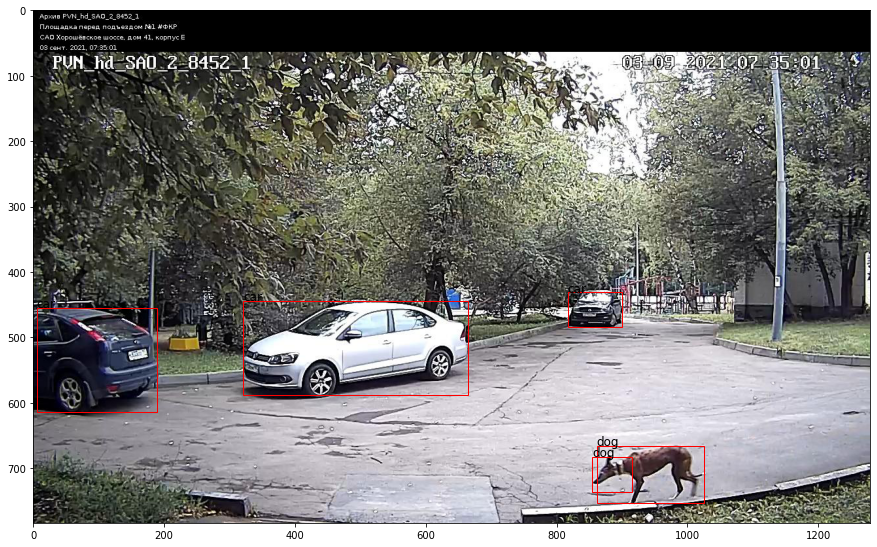

In [44]:
draw_pic_with_rect(image_torch, boxes, labels)

In [46]:
print(labels.tolist().index(18))

2


In [53]:
cropped_image = get_cropped_image(image_torch, boxes[2], 1.2)

In [54]:
cropped_image_numpy = (cropped_image[0].detach().permute(1, 2, 0).numpy() * 256).astype(np.uint8)

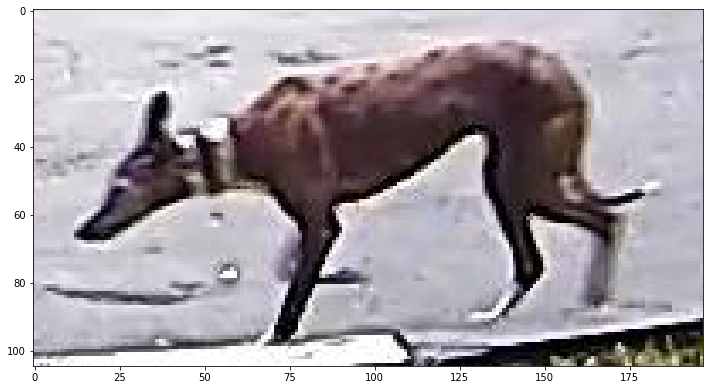

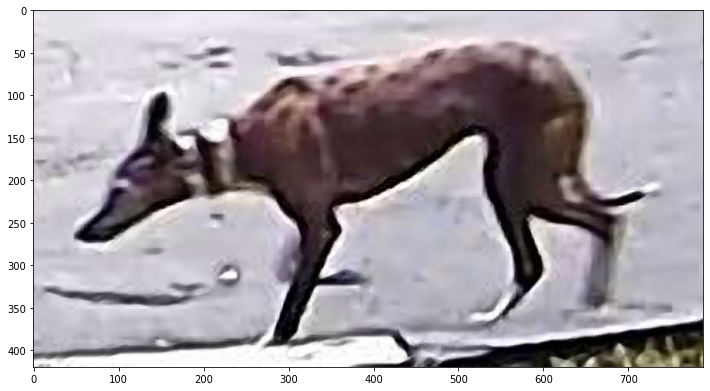

In [55]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()

path = "FSRCNN_x4.pb"
sr.readModel(path)
sr.setModel("fsrcnn",4)
result = sr.upsample(cropped_image_numpy)
plt.figure(figsize=(12,8))
plt.imshow(cropped_image_numpy)
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(result)
plt.show()

In [66]:
model_classification_cat_dog(
    torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225],
    )((torch.from_numpy(cropped_image_numpy).to(dtype=torch.float32).permute(2, 0, 1) / 256).unsqueeze_(0))
)

tensor([[-0.6505, -0.3461]], grad_fn=<AddmmBackward>)

In [18]:
model_classification_dog_breed_fp = torchvision.\
models.resnet50(pretrained = True)

n_inputs = 1000
n_classes = 61
model_classification_dog_breed_sp = nn.Sequential(
                      nn.Linear(n_inputs, 512),
                      nn.Tanh(),
                      nn.Dropout(0.3),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Linear(256, n_classes)
                      )
model_classification_dog_breed_sp.load_state_dict(
    torch.load('/content/model_classification_dog_breeds.pt', map_location=torch.device('cpu'))
    )

model_classification_dog_breed = nn.Sequential(model_classification_dog_breed_fp, 
                                               model_classification_dog_breed_sp)

In [20]:
model_classification_cat_dog_fp = torchvision.\
models.resnet34(pretrained = True)

n_inputs = 1000
n_classes = 2
torch.manual_seed(42)
model_classification_cat_dog_sp = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      )


model_classification_cat_dog_sp.load_state_dict(
    torch.load('/content/linear_model_cat_dogs_bq.pt', map_location=torch.device('cpu'))
    )

model_classification_cat_dog = nn.Sequential(model_classification_cat_dog_fp, 
                                             model_classification_cat_dog_sp)


In [15]:
model_detection = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]